In [1]:
# imports for array-handling and plotting
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [2]:
if 0:
    !pip install mlflow
import mlflow
mlflow.tracking.set_tracking_uri(r'http://127.0.0.1:5000')
print('start tracking on: ',mlflow.tracking.get_tracking_uri()) 
import datetime 
exp_id = mlflow.set_experiment('exp-'+str(datetime.datetime.now().second))
print(f'start experiment {exp_id}')

start tracking on:  http://127.0.0.1:5000
INFO: 'exp-58' does not exist. Creating a new experiment
start experiment None


In [3]:
def build_model():
    # building a linear stack of layers with the sequential model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    print(model.summary())

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [4]:
def plot_digits(X_train, y_train):
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(X_train[i], cmap='gray', interpolation='none')
        plt.title("Class {}".format(y_train[i]))
        plt.xticks([])
        plt.yticks([])
    fig.savefig(r'./output/digits.png', bbox_inches='tight')
    mlflow.log_artifact(r'output/digits.png')
    fig

def plot_results(model):
    # plotting the metrics
    fig = plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(model.history['acc'])
    plt.plot(model.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(2,1,2)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout()
    fig.savefig(r'output/results.png', bbox_inches='tight')
    mlflow.log_artifact(r'output/results.png')
    fig

In [5]:
def softmax(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return np.max(exps / np.sum(exps))

### load mnist train & test

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


### building the input vector from the 28x28 pixels  

In [7]:
f = plt.figure()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)     
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


### one-hot encoding using keras' numpy-related utilities

In [8]:
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


### split train to labeled & unlabeld

In [9]:
labeled_size = .02
mlflow.log_param("labeled_size", labeled_size)

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train,
                                                                      train_size=labeled_size, stratify=y_train)
print("X_labeled shape", X_labeled.shape)
print("Y_labeled shape", Y_labeled.shape)
print("X_unlabeled shape", X_unlabeled.shape)
print("Y_unlabeled shape", Y_unlabeled.shape)
mlflow.log_param("labeled_sampels", X_labeled.shape[0])
mlflow.log_param("unlabeled_sampels", X_unlabeled.shape[0])

X_labeled shape (1200, 784)
Y_labeled shape (1200, 10)
X_unlabeled shape (58800, 784)
Y_unlabeled shape (58800, 10)


/home/yuval/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### build model :

In [10]:
model = build_model() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
__________

#### loop few iterations 

#### training the model on the labeled data and saving metrics in history

In [11]:
iteration = 0
history = model.fit(X_labeled, Y_labeled, batch_size=128, epochs=30, verbose=4, validation_data=(X_test, Y_test))

# check accuracy on test data
metrics = model.evaluate(X_test, y=Y_test, batch_size=128)

print('\n accuracy after {} iterations :'.format(iteration))

for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(metrics[i]))
    mlflow.log_metric(str(model.metrics_names[i]), metrics[i])   


Train on 1200 samples, validate on 10000 samples
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
 9344/10000 [===========================>..] - ETA: 0s
 accuracy after 0 iterations :
loss: 0.371337190819
acc: 0.9161


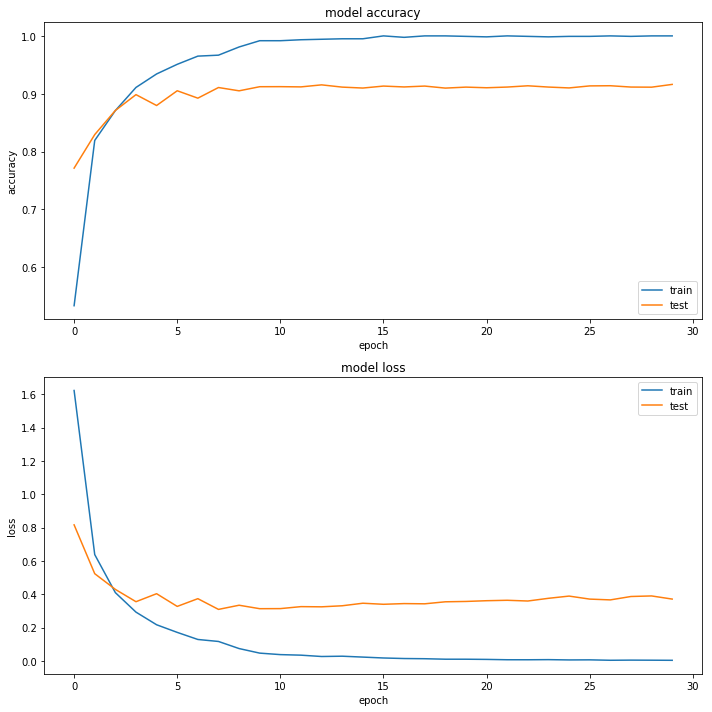

In [12]:
plot_results(history)

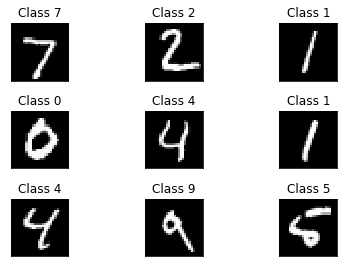

In [13]:
plot_digits(X_test.reshape(X_test.shape[0],28,28),y_test)

### use the model to predict unlabeled data and create pseudo labeles

In [14]:
iteration = iteration+1

threshold = .98
predict_proba = model.predict_proba(X_unlabeled)

# select unlabeled samples with predictions probabilty above threshold :
# TODO :softmax probas 
pseudo_index = np.max(predict_proba,axis=1) > threshold 
mlflow.log_param('threshold',threshold)   
print (f'\n using threshold of {threshold} - predicts {pseudo_index[pseudo_index].shape} \
pseudo labels from {pseudo_index.shape} unlabeld samples')

predict = model.predict(X_unlabeled)
X_pseudo_labeled = X_unlabeled[pseudo_index]
Y_pseudo_labeled = predict[pseudo_index]                           

# add pseudo labeled samples to labeled data :
X_mixed_labeled = np.concatenate((X_labeled, X_pseudo_labeled ), axis=0)
Y_mixed_labeled = np.concatenate((Y_labeled, Y_pseudo_labeled ), axis=0)

57728/58800 [============================>.] - ETA: 0s
 using threshold of 0.98 - predicts (46275,) pseudo labels from (58800,) unlabeld samples


### check pseudo labels (compare to original train labels) : 

In [15]:
y_pseudo_labeled = np.argmax(Y_pseudo_labeled,axis=1)
y_unlabeled = np.argmax(Y_unlabeled,axis=1)

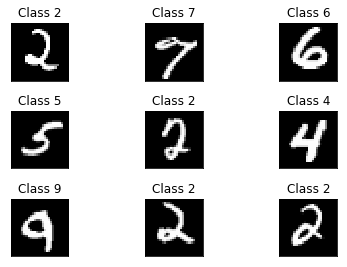

In [16]:
plot_digits(X_pseudo_labeled.reshape(X_pseudo_labeled.shape[0],28,28),y_pseudo_labeled)

   ### training the model on the pseudo labeled data and saving metrics in history

In [17]:
history = model.fit(X_mixed_labeled, Y_mixed_labeled, batch_size=128, epochs=30, verbose=2, validation_data=(X_test, Y_test))

# check accuracy on test data
metrics = model.evaluate(X_test, y=Y_test, batch_size=128)
print('\n accuracy after {} iterations :'.format(iteration))
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(metrics[i]))
    mlflow.log_metric('mixed_labeled_'+ str(model.metrics_names[i]), metrics[i])     
    print('\n')

Train on 47475 samples, validate on 10000 samples
Epoch 1/30
3s - loss: 0.0206 - acc: 0.9972 - val_loss: 0.4496 - val_acc: 0.9039
Epoch 2/30
3s - loss: 0.0181 - acc: 0.9980 - val_loss: 0.3817 - val_acc: 0.9222
Epoch 3/30
3s - loss: 0.0172 - acc: 0.9984 - val_loss: 0.5007 - val_acc: 0.9043
Epoch 4/30
3s - loss: 0.0192 - acc: 0.9979 - val_loss: 0.3691 - val_acc: 0.9209
Epoch 5/30
3s - loss: 0.0152 - acc: 0.9992 - val_loss: 0.3657 - val_acc: 0.9211
Epoch 6/30
3s - loss: 0.0126 - acc: 0.9999 - val_loss: 0.3588 - val_acc: 0.9192
Epoch 7/30
3s - loss: 0.0136 - acc: 0.9995 - val_loss: 0.3525 - val_acc: 0.9217
Epoch 8/30
3s - loss: 0.0130 - acc: 0.9998 - val_loss: 0.3393 - val_acc: 0.9226
Epoch 9/30
3s - loss: 0.0142 - acc: 0.9993 - val_loss: 0.4189 - val_acc: 0.9150
Epoch 10/30
3s - loss: 0.0244 - acc: 0.9965 - val_loss: 0.3577 - val_acc: 0.9248
Epoch 11/30
3s - loss: 0.0140 - acc: 0.9997 - val_loss: 0.3789 - val_acc: 0.9180
Epoch 12/30
3s - loss: 0.0132 - acc: 0.9997 - val_loss: 0.3279 - val

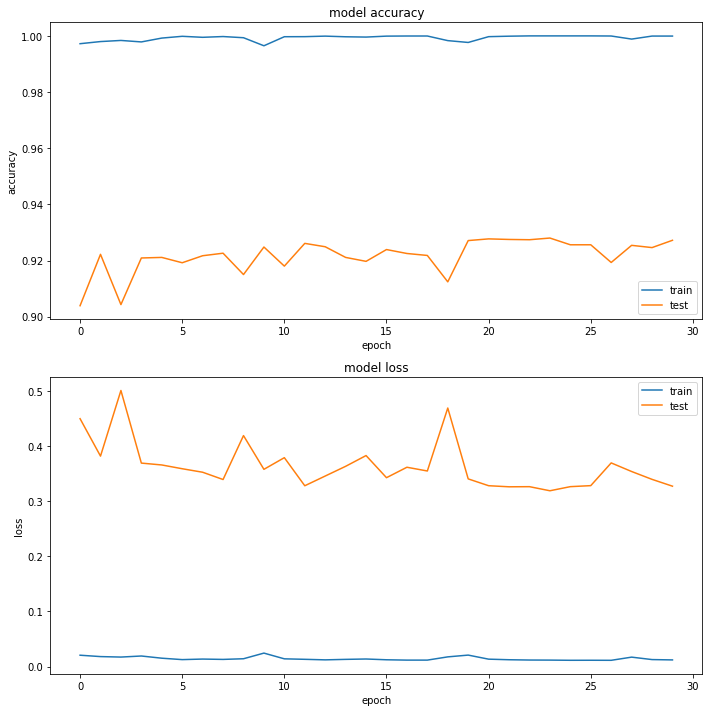

In [18]:
plot_results(history)
figsize=(15,15)

#### train on new random initialized model 

In [19]:
new_model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
__________

In [20]:
history = new_model.fit(X_mixed_labeled, Y_mixed_labeled, batch_size=128, epochs=30, verbose=2, validation_data=(X_test, Y_test))

# check accuracy on test data
metrics = new_model.evaluate(X_test, y=Y_test, batch_size=128)
print('\n accuracy on new model with pseudo labels :')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(metrics[i]))    
    print('\n')
    mlflow.log_metric('mixed_new_model_'+str(model.metrics_names[i]), metrics[i]) 

Train on 47475 samples, validate on 10000 samples
Epoch 1/30
3s - loss: 0.0958 - acc: 0.9755 - val_loss: 0.3966 - val_acc: 0.9137
Epoch 2/30
3s - loss: 0.0231 - acc: 0.9967 - val_loss: 0.3772 - val_acc: 0.9155
Epoch 3/30
3s - loss: 0.0198 - acc: 0.9975 - val_loss: 0.3843 - val_acc: 0.9184
Epoch 4/30
3s - loss: 0.0153 - acc: 0.9992 - val_loss: 0.3596 - val_acc: 0.9211
Epoch 5/30
3s - loss: 0.0138 - acc: 0.9996 - val_loss: 0.3620 - val_acc: 0.9210
Epoch 6/30
4s - loss: 0.0178 - acc: 0.9981 - val_loss: 0.4312 - val_acc: 0.9136
Epoch 7/30
3s - loss: 0.0175 - acc: 0.9984 - val_loss: 0.3578 - val_acc: 0.9228
Epoch 8/30
3s - loss: 0.0134 - acc: 0.9998 - val_loss: 0.3575 - val_acc: 0.9207
Epoch 9/30
3s - loss: 0.0125 - acc: 0.9999 - val_loss: 0.3370 - val_acc: 0.9250
Epoch 10/30
3s - loss: 0.0118 - acc: 1.0000 - val_loss: 0.3308 - val_acc: 0.9235
Epoch 11/30
3s - loss: 0.0119 - acc: 1.0000 - val_loss: 0.3318 - val_acc: 0.9235
Epoch 12/30
3s - loss: 0.0244 - acc: 0.9960 - val_loss: 0.3943 - val

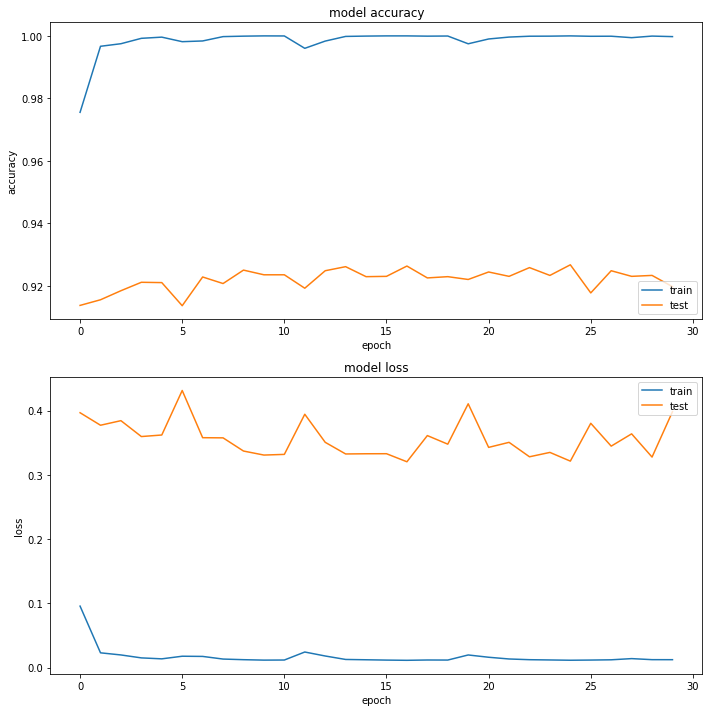

In [21]:
plot_results(history)